<a href="https://colab.research.google.com/github/aswin-suresh12/Team-repository-----QML-for-Conspicuity-Detection-in-Production/blob/main/Variational_Classifier_QML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall pennylane

In [2]:
!pip install pennylane --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.6 MB/s eta 0:00:00


# BIAS ENCODING

In [34]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer # A classical ML optimizer which works on the Gradient to minimize the cost function.

In [9]:
dev = qml.device("default.qubit")  # Defining a device

In [4]:
# Defining a Layer which forms the basic building block for our VQ circuit. Here we use a 4 qubit circuit with arbitrary rotations on each qubit and entangles all of the qubit with one another.

def layer(layer_weights):
    for wire in range(4):
        qml.Rot(*layer_weights[wire], wires=wire) #Arbitraty rotation gate

    for wires in ([0, 1], [1, 2], [2, 3], [3, 0]): # Entangling
        qml.CNOT(wires)

In [35]:
#State prepration

def state_preparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

In [36]:
# Defining the QNode

@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

In [37]:
#Adding classical bias parameter

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [38]:
#Definig the cost funtion as a square loss funtion between labelled data and model prediction. Takes Labels and Predictions as paramenters.
# We use a call to qml.math.stack to allow subtracting the arrays directly


def square_loss(labels, predictions):
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

In [39]:
#Definig accuracy of prdictions

def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

In [40]:
# Defining a function cost for learning purpose which takes the weight , classical bias , Input data X and Labelled data Y to return the cost after each optimization

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

#Training and testing modules


In [41]:
data = np.loadtxt("variational_classifier/data/parity_train.txt", dtype=int)
X = np.array(data[:, :-1])
Y = np.array(data[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1


In [42]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]]
Bias:  0.0


In [43]:
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

In [44]:
weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

Iter:    1 | Cost: 1.7599712 | Accuracy: 0.6000000
Iter:    2 | Cost: 1.7598040 | Accuracy: 0.6000000
Iter:    3 | Cost: 1.5981997 | Accuracy: 0.6000000
Iter:    4 | Cost: 1.7514516 | Accuracy: 0.6000000
Iter:    5 | Cost: 1.5400747 | Accuracy: 0.6000000
Iter:    6 | Cost: 1.3418667 | Accuracy: 0.6000000
Iter:    7 | Cost: 2.9866839 | Accuracy: 0.4000000
Iter:    8 | Cost: 1.5486219 | Accuracy: 0.4000000
Iter:    9 | Cost: 1.4862661 | Accuracy: 0.6000000
Iter:   10 | Cost: 1.4357274 | Accuracy: 0.6000000
Iter:   11 | Cost: 1.3987486 | Accuracy: 0.5000000
Iter:   12 | Cost: 1.2451466 | Accuracy: 0.6000000
Iter:   13 | Cost: 1.4336315 | Accuracy: 0.6000000
Iter:   14 | Cost: 2.6530443 | Accuracy: 0.4000000
Iter:   15 | Cost: 1.0258561 | Accuracy: 0.6000000
Iter:   16 | Cost: 1.5798042 | Accuracy: 0.4000000
Iter:   17 | Cost: 1.9348532 | Accuracy: 0.6000000
Iter:   18 | Cost: 0.9429694 | Accuracy: 0.6000000
Iter:   19 | Cost: 2.6588980 | Accuracy: 0.6000000
Iter:   20 | Cost: 1.1593458 | 

In [47]:
data = np.loadtxt("variational_classifier/data/parity_test.txt", dtype=int)
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)

x = [0 0 0 0], y = -1, pred=1.0
x = [0 0 1 1], y = -1, pred=1.0
x = [1 0 1 0], y = -1, pred=-1.0
x = [1 1 1 0], y = 1, pred=-1.0
x = [1 1 0 0], y = -1, pred=-1.0
x = [1 1 0 1], y = 1, pred=-1.0
Accuracy on unseen data: 0.3333333333333333


# AMPLITUDE EMBEDING

#Iris Classification

In [48]:
# Preparing the routine for state prepration by converting the input state into angles.


def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

In [49]:
#Testing the state preparation routine with a random state x


x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):
    state_preparation(angles)

    return qml.state()


state = test(ang)

print("x               : ", np.round(x, 6))
print("angles          : ", np.round(ang, 6))
print("amplitude vector: ", np.round(np.real(state), 6))

x               :  [0.538968 0.795036 0.278265 0.      ]
angles          :  [ 0.563975 -0.        0.       -0.975046  0.975046]
amplitude vector:  [ 0.538968  0.795036  0.278265 -0.      ]


In [27]:
#Updating the Layer as well as the cost function.

def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])


def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)

In [52]:
#Loading the IRIS Dataset


data = np.loadtxt("variational_classifier/data/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

Y = data[:, -1]

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.1  0.1 ]
First X sample (normalized): [0.46420708 0.87038828 0.11605177 0.11605177]
First features sample      : [ 0.32973573 -0.78539816  0.78539816 -1.080839    1.080839  ]


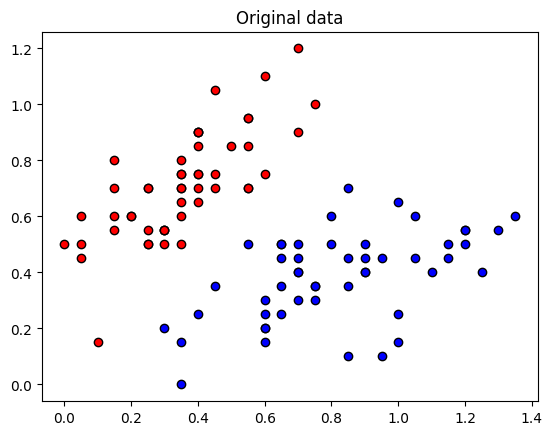

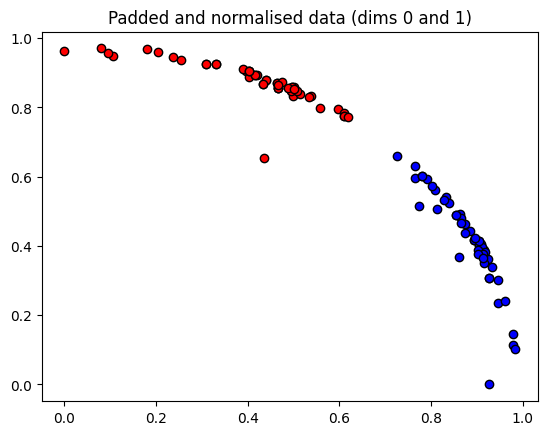

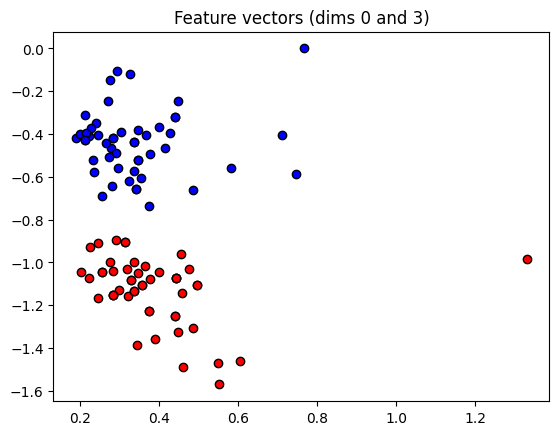

In [53]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Padded and normalised data (dims {dim1} and {dim2})")
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature vectors (dims {dim1} and {dim2})")
plt.show()

# Training and Testing

In [55]:
#Spilitting data into training and validation steps.

np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

In [56]:
# num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [57]:
# Minimizing cost using optimizer

opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )

Iter:     2 | Cost: 1.6982376 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     4 | Cost: 1.5347820 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:     6 | Cost: 1.3050442 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:     8 | Cost: 1.0892118 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    10 | Cost: 0.9631402 | Acc train: 0.6000000 | Acc validation: 0.6000000
Iter:    12 | Cost: 1.0350620 | Acc train: 0.5200000 | Acc validation: 0.4400000
Iter:    14 | Cost: 1.1810712 | Acc train: 0.5200000 | Acc validation: 0.4400000
Iter:    16 | Cost: 1.0539995 | Acc train: 0.5200000 | Acc validation: 0.4400000
Iter:    18 | Cost: 0.8341944 | Acc train: 0.5866667 | Acc validation: 0.5200000
Iter:    20 | Cost: 0.7413311 | Acc train: 0.7600000 | Acc validation: 0.7600000
Iter:    22 | Cost: 0.6712512 | Acc train: 0.8400000 | Acc validation: 0.8000000
Iter:    24 | Cost: 0.5906363 | Acc train: 0.8933333 | Acc validation: 0.8400000
Iter:    26 | Cost: 0.511708

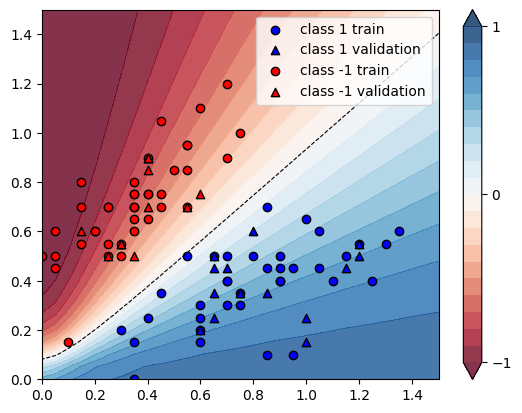

In [58]:
# Plotting the output

plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()